# Lab Assignment 5

## Austin Booth

Link:

### Exercise 2, continued

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# define constants from lab 2
CpH = 8.7738
CpS = 2.9110
Ua = 0.0495195
Ub = 0.273355
Uc = 0.0387042

# constant parameters
P1 = 200               # P1 units
P2 = 100               # P2 units
alpha = 0.00016        # watts / (units P1 * percent U1)

# construct arrays
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH], [0, 0, Ub/CpS, -Ub/CpS]])  # 4x4
Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])     # 4x2
Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])           # 4x1
C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])                   # 2x4

# print arrays
print('A:')
print(A)
print('Bu:')
print(Bu)
print('Bd:')
print(Bd)
print('C:')
print(C)

A:
[[-0.04121119  0.03115583  0.00441134  0.        ]
 [ 0.09390416 -0.09390416  0.          0.        ]
 [ 0.00441134  0.         -0.04121119  0.03115583]
 [ 0.          0.          0.09390416 -0.09390416]]
Bu:
[[0.00364722 0.        ]
 [0.         0.        ]
 [0.         0.00182361]
 [0.         0.        ]]
Bd:
[[0.00564402]
 [0.        ]
 [0.00564402]
 [0.        ]]
C:
[[0 1 0 0]
 [0 0 0 1]]


In [16]:
# get the eigenvalues of A and report time constants
eigenvalues, _ = np.linalg.eig(A)
print('Eigenvalues of A are:', eigenvalues)
print('Time constants of A are:', -1.0/np.real(eigenvalues), 'seconds')

Eigenvalues of A are: [-0.00418921 -0.01053125 -0.12899543 -0.12651479]
Time constants of A are: [238.70855226  94.95550576   7.75221248   7.90421389] seconds


### Exercise 3

In [24]:
# set ambient temperature and initialize disturbance and x variables
from tclab import TCLab, setup, clock, Historian, Plotter

with TCLab() as lab:
    T1 = lab.T1
    T2 = lab.T2
    Tamb = (T1 + T2) / 2
    print('T_amb:', T_amb)
    
d_initial = [Tamb]                       # initial disturbance input
x_initial = np.array([Tamb, Tamb, Tamb, Tamb])       # initial steady state

TCLab version 0.4.9
Arduino Leonardo connected on port COM6 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
T_amb: 24.1695
TCLab disconnected successfully.


In [25]:
# define relay controller function
def relay(MV_min, MV_max):
    MV = MV_min
    while True:
        SP, PV = yield MV
        MV = MV_max if PV < SP else MV_min

In [26]:
# define observer function
def tclab_observer(L):
    # initialize variables
    t_now = 0
    x_now = x_initial                     # steady state temperature variables
    d = d_initial                         # estimate of unmeasured disturbances
    
    while True:
        # yield current state, get MV for next period
        t_next, Q1, Q2, T1, T2 = yield x_now
        
        # model prediction
        u = np.array([Q1, Q2])
        d = [Tamb]
        x_predict = x_now + (t_next - t_now)*(np.dot(A, x_now) + np.dot(Bu, u) + np.dot(Bd, d))
        
        # measurement correction
        y = np.array([T1, T2])
        x_correct = x_predict - (t_next - t_now)*np.dot(L, np.dot(C, x_predict) - y)
        
        # update time and state
        t_now = t_next
        x_now = x_correct

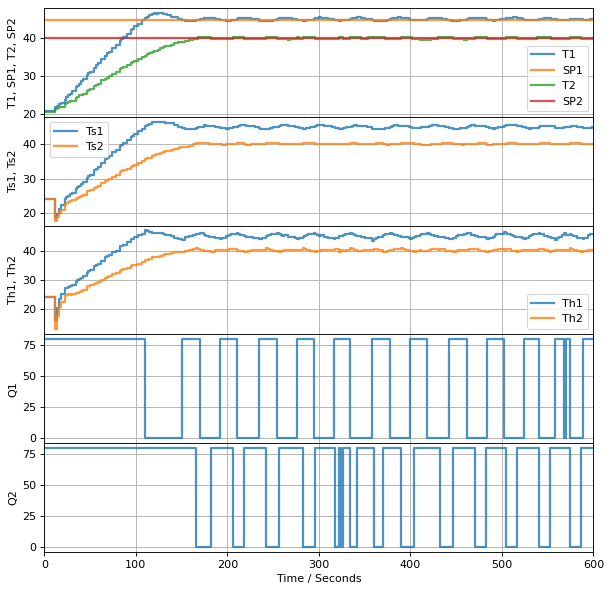

TCLab Model disconnected successfully.


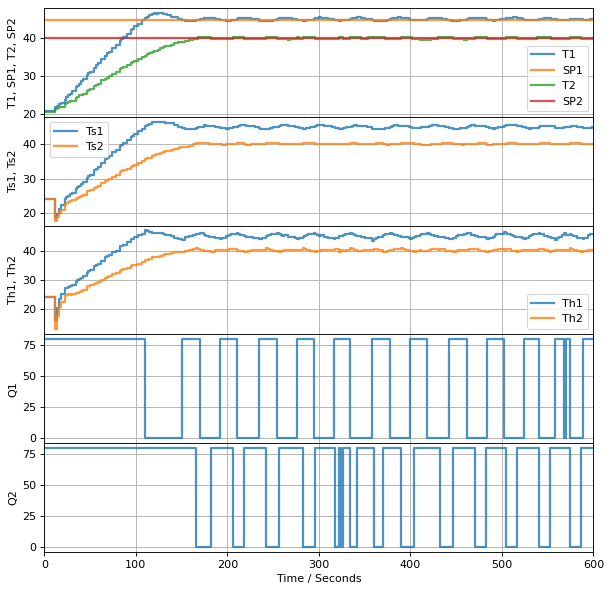

In [29]:
# test function with virtual lab and constant SP1 and SP2
def SP1(t):
    return 45
def SP2(t):
    return 40

t_final = 600        # run time
t_step = 2

# create a controller instance
controller = relay(0, 80)
U1 = next(controller)
U2 = U1

# create estimator instance
L = np.array([[0.4, 0], [0.2, 0], [0, 0.4], [0, 0.2]])
observer = tclab_observer(L)
Th1, Ts1, Th2, Ts2 = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1), 
                   ('SP2', lambda: SP2(t)), ('T2', lambda: lab.T2), ('Q2', lab.Q2), 
                   ('Th1', lambda: Th1), ('Ts1', lambda: Ts1),
                   ('Th2', lambda: Th2), ('Ts2', lambda: Ts2)])
    
    p = Plotter(h, t_final, layout=[['T1', 'SP1', 'T2', 'SP2'], ['Ts1', 'Ts2'], ['Th1', 'Th2'], ['Q1'], ['Q2']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        Th1, Ts1, Th2, Ts2 = observer.send([t, U1, U2, T1, T2])   # <= use the last value of U1 to estimate the current Th, Ts
        U1 = controller.send([SP1(t), T1])  # <= compute the value of U1 to use for the next time interval
        U2 = controller.send([SP2(t), T2])
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

### Exercise 4

In [30]:
# create new set point functions
def SP1(t):
    if t >= 300:
        return 40
    else:
        return 45
    
def SP2(t):
    if t >= 300:
        return 45
    else:
        return 40

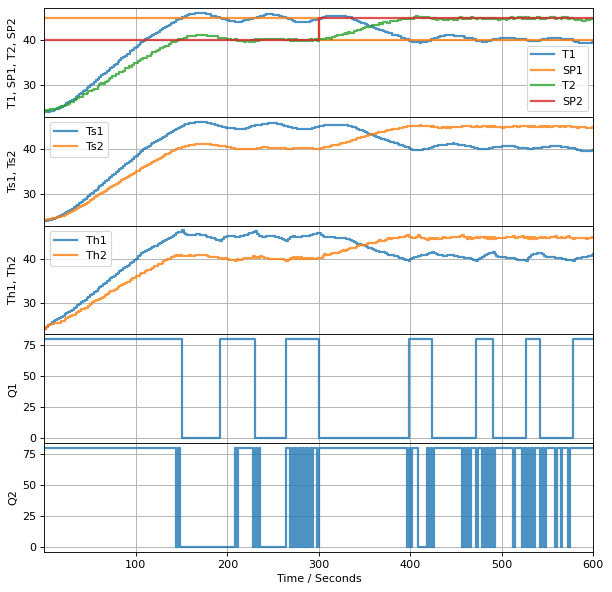

TCLab disconnected successfully.


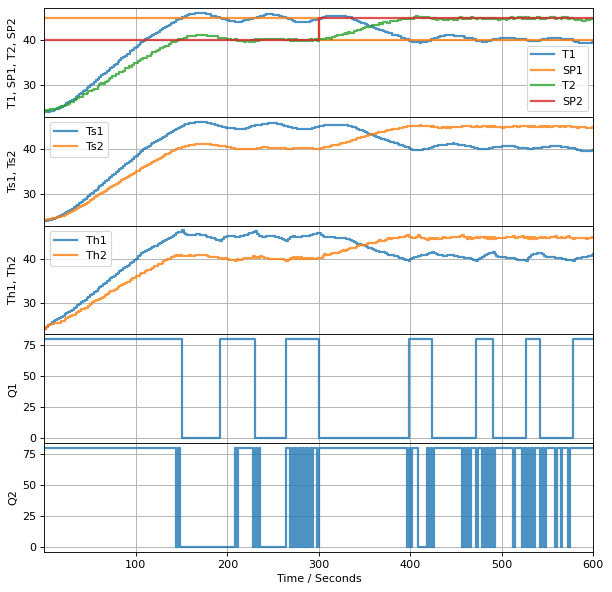

In [31]:
# run function live
from tclab import TCLab, clock, Historian, Plotter

t_final = 600        # run time
t_step = 2

# create a controller instance
controller = relay(0, 80)
U1 = next(controller)
U2 = U1

# create estimator instance
L = np.array([[0.4, 0], [0.2, 0], [0, 0.4], [0, 0.2]])
observer = tclab_observer(L)
Th1, Ts1, Th2, Ts2 = next(observer)

# execute the event loop
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1), 
                   ('SP2', lambda: SP2(t)), ('T2', lambda: lab.T2), ('Q2', lab.Q2), 
                   ('Th1', lambda: Th1), ('Ts1', lambda: Ts1),
                   ('Th2', lambda: Th2), ('Ts2', lambda: Ts2)])
    
    p = Plotter(h, t_final, layout=[['T1', 'SP1', 'T2', 'SP2'], ['Ts1', 'Ts2'], ['Th1', 'Th2'], ['Q1'], ['Q2']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        Th1, Ts1, Th2, Ts2 = observer.send([t, U1, U2, T1, T2])   # <= use the last value of U1 to estimate the current Th, Ts
        U1 = controller.send([SP1(t), T1])  # <= compute the value of U1 to use for the next time interval
        U2 = controller.send([SP2(t), T2])
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

### Exercise 4, Part 2

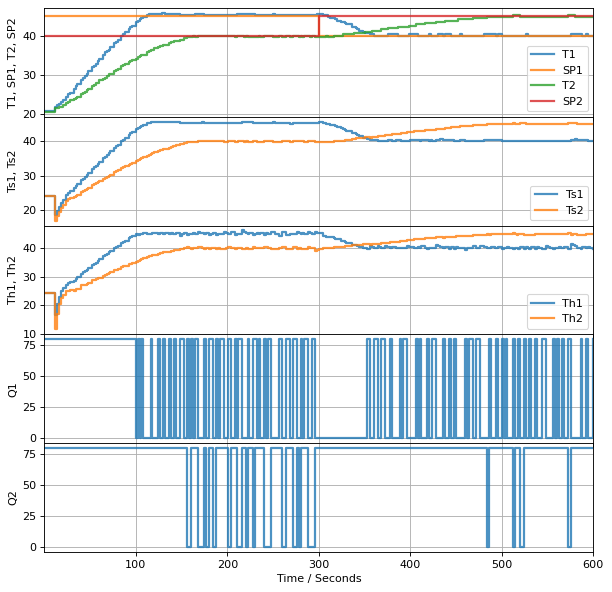

TCLab Model disconnected successfully.


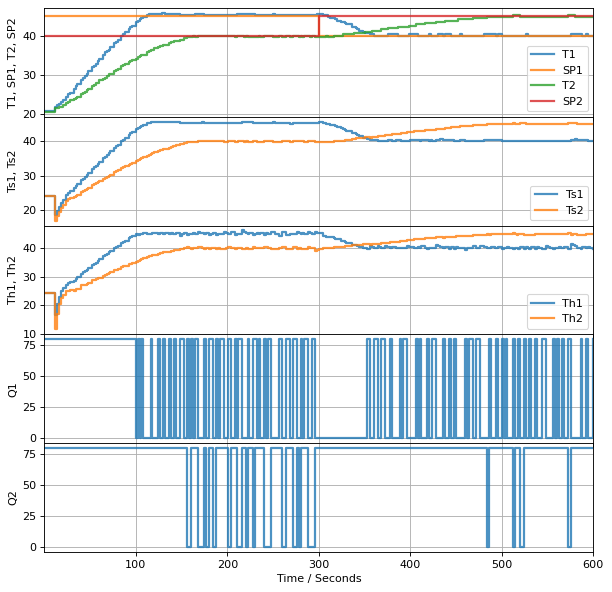

In [32]:
# run function virtually using predicted Th1, Th2 as inputs
from tclab import TCLab, setup, clock, Historian, Plotter

t_final = 600        # run time
t_step = 2

# create a controller instance
controller = relay(0, 80)
U1 = next(controller)
U2 = U1

# create estimator instance
L = np.array([[0.4, 0], [0.2, 0], [0, 0.4], [0, 0.2]])
observer = tclab_observer(L)
Th1, Ts1, Th2, Ts2 = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1), 
                   ('SP2', lambda: SP2(t)), ('T2', lambda: lab.T2), ('Q2', lab.Q2), 
                   ('Th1', lambda: Th1), ('Ts1', lambda: Ts1),
                   ('Th2', lambda: Th2), ('Ts2', lambda: Ts2)])
    
    p = Plotter(h, t_final, layout=[['T1', 'SP1', 'T2', 'SP2'], ['Ts1', 'Ts2'], ['Th1', 'Th2'], ['Q1'], ['Q2']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        Th1, Ts1, Th2, Ts2 = observer.send([t, U1, U2, T1, T2])   # <= use the last value of U1 to estimate the current Th, Ts
        U1 = controller.send([SP1(t), Th1]) # using Th1
        U2 = controller.send([SP2(t), Th2]) # using Th2
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

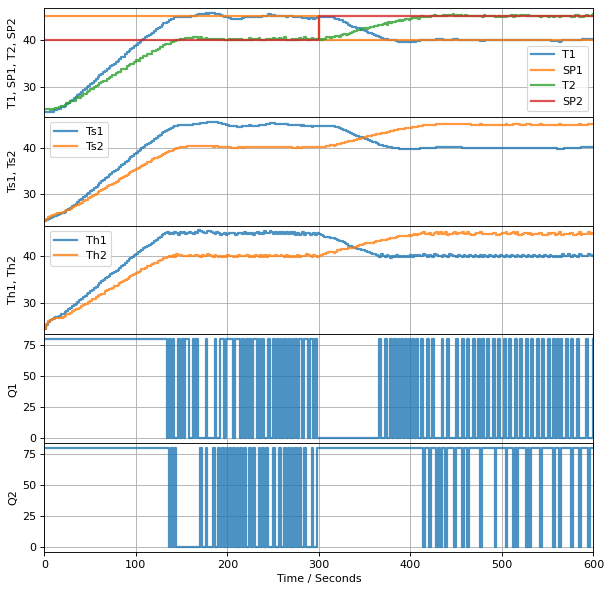

TCLab disconnected successfully.


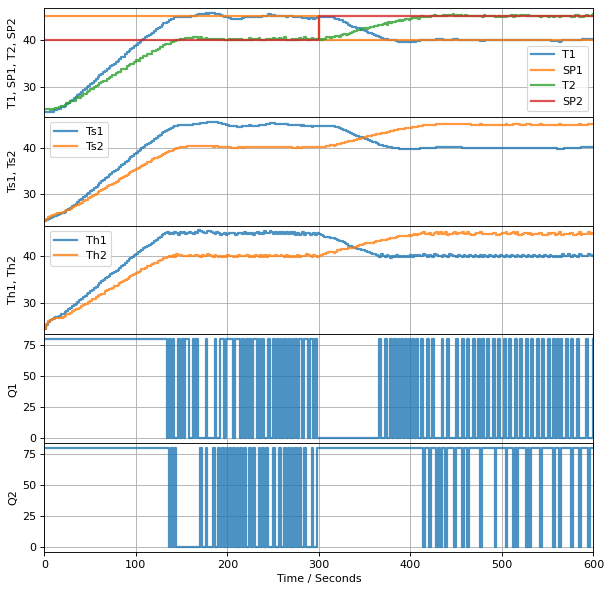

In [33]:
# run function live
from tclab import TCLab, clock, Historian, Plotter

t_final = 600        # run time
t_step = 2

# create a controller instance
controller = relay(0, 80)
U1 = next(controller)
U2 = U1

# create estimator instance
L = np.array([[0.4, 0], [0.2, 0], [0, 0.4], [0, 0.2]])
observer = tclab_observer(L)
Th1, Ts1, Th2, Ts2 = next(observer)

# execute the event loop
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1), 
                   ('SP2', lambda: SP2(t)), ('T2', lambda: lab.T2), ('Q2', lab.Q2), 
                   ('Th1', lambda: Th1), ('Ts1', lambda: Ts1),
                   ('Th2', lambda: Th2), ('Ts2', lambda: Ts2)])
    
    p = Plotter(h, t_final, layout=[['T1', 'SP1', 'T2', 'SP2'], ['Ts1', 'Ts2'], ['Th1', 'Th2'], ['Q1'], ['Q2']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        Th1, Ts1, Th2, Ts2 = observer.send([t, U1, U2, T1, T2])   # <= use the last value of U1 to estimate the current Th, Ts
        U1 = controller.send([SP1(t), Th1]) # using Th1
        U2 = controller.send([SP2(t), Th2]) # using Th2
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

The closed-loop control (which controlled and used the estimated temperature as an input instead of the measured temperature) allowed for closer tracking of the set point. Oscillations between the maximum and minimum power settings were much quicker and allowed the temperature to follow the set point with greater precision. Both the measured and the estimated temperatures had less deviation from the set point; estimated temperatures in particular had less irregular, "spiky" graphs. 

This difference likely occurred because the new controller could base its state estimation on the existing mathematical model, and how the temperatures SHOULD be reacting to manipulated variables, instead of waiting to react to the previous temperature measurements and then determine the new MV value. The previous controller operated on a noticeable delay, while this last one could switch Q1 and Q2 almost instantaneously to produce much greater sensitivity.